In [15]:
import os
import sys

file = '../../data_demo/raw_data/20212017_Dube_NPX_2021-12-13_OID30253_corrected.csv'
if not os.path.isfile(file):
    print(f'File {file} not found. Please run from the project root folder.')
    sys.exit(1)

import pandas as pd
import numpy as np

PR1: normothermic, pre-acclimation
PT1: hyperthermic, pre-acclimation
PR2: normothermic, post-acclimation
PT2: hyperthermic, post-acclimation

In [16]:
df = pd.read_csv(file, sep=';', header=0)
df_original = df.copy()
df = df.replace({np.nan: None})

# Remove Controls   
df = df[df['SampleID'].str.contains('CONTROL') == False]

# Remove failed samples
df = df[df['QC_Warning'] == 'PASS']

# make Assay as index, sampleid as columns and npx as values 
df = df.pivot(index='OlinkID', columns='SampleID', values='NPX')

# OlinkID gene and LOD map
gene_lod_map = df_original.loc[:, ['OlinkID', 'Assay', 'LOD']].drop_duplicates().set_index('OlinkID').copy()


In [17]:
# Filter olink_ids that are all below LOD
def filter_below_lod(df, gene_lod_map):
    to_keep = []
    for olink_id in df.index:
        lod = gene_lod_map.loc[olink_id, 'LOD']
        values = df.loc[olink_id, :].values
        if np.any(values > lod):
            to_keep.append(olink_id)
    return df.loc[to_keep, :]
print(f'Original shape: {df.shape}')

df = filter_below_lod(df, gene_lod_map)

print(f'Filtered shape: {df.shape}')


Original shape: (1471, 40)
Filtered shape: (1309, 40)


In [18]:
# Normalization (per sample) given that NPX values are log2 scaled
df = df.subtract(df.median(axis=0), axis=1)
df = df.divide(df.std(axis=0), axis=1)
df = df.fillna(0)  # fill NaN values with 0
df.head()

#write dataframe to file
df.to_csv('../../data_demo/processed_data/olink_normalized.csv')

/home/siva/miniforge3/envs/pgx_statin_response/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/siva/miniforge3/envs/pgx_statin_response/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1000x800 with 0 Axes>

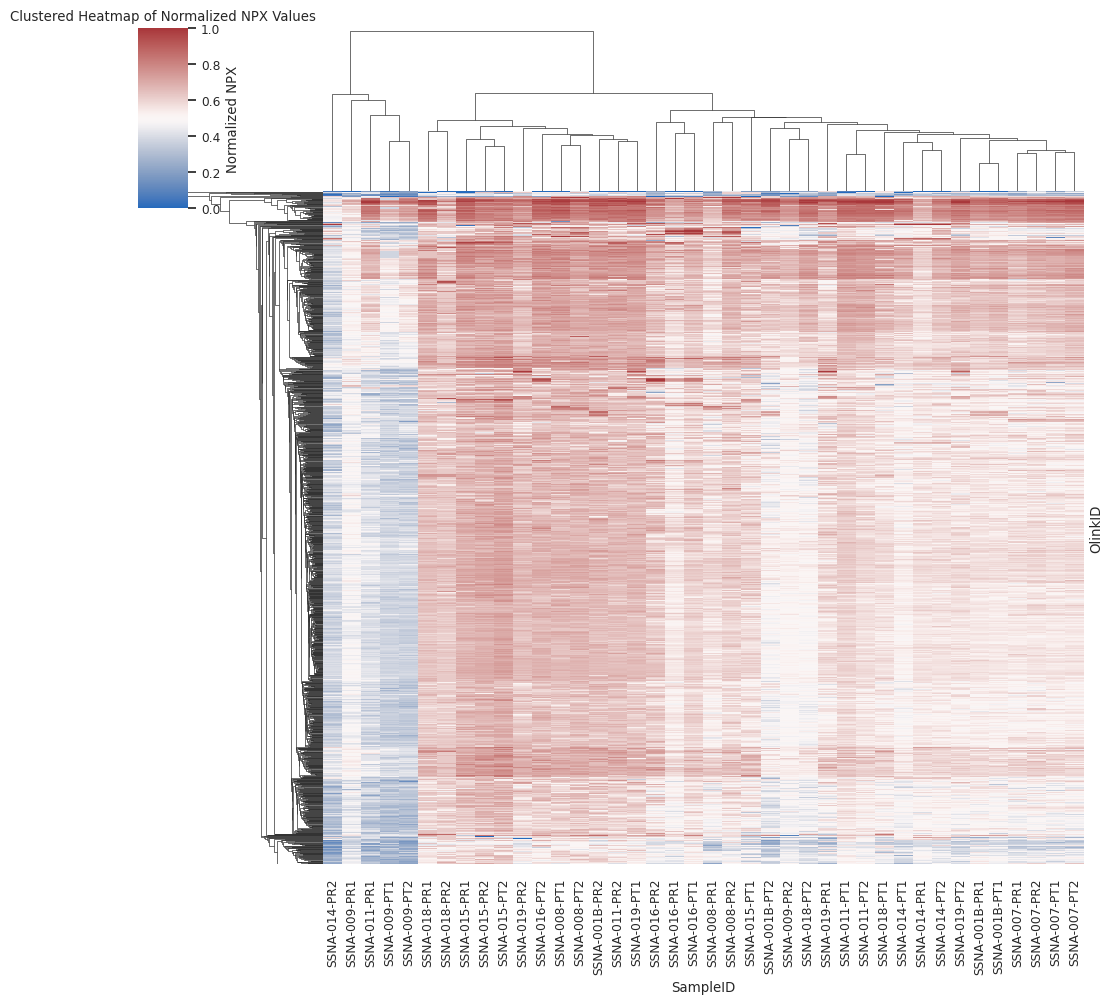

In [19]:
# Clustered heatmap visualization using seaborn (inspired by omics-cancer-explore/visualization.py)
import seaborn as sns
import matplotlib.pyplot as plt
import dash_bio as dashbio

# Use the normalized dataframe 'df' as heatmap_data
heatmap_data = df

# Create a clustered heatmap using seaborn
sns.set(font_scale=0.8)
plt.figure(figsize=(10, 8))
sns_clustermap = sns.clustermap(heatmap_data, cmap='vlag', standard_scale=1, method='average', metric='euclidean',
                                cbar_kws={'label': 'Normalized NPX'}, yticklabels=False)
plt.title('Clustered Heatmap of Normalized NPX Values')
plt.show()
